In [1]:
import findspark
from pyspark.sql.functions import col, when
import matplotlib.pyplot as plt
from pyspark.sql.functions import when, col
from pyspark.sql import SparkSession

In [2]:
findspark.init()
#start Spark session
spark = SparkSession.builder.appName("sparkFunctions").getOrCreate()

In [3]:
from pyspark import SparkFiles
csv_file_paths = [
    "Resources/CurrentPopulationSurvey_1981.csv",
    "Resources/CurrentPopulationSurvey_1990.csv",
    "Resources/CurrentPopulationSurvey_1999.csv",
    "Resources/CurrentPopulationSurvey_2007.csv",
    "Resources/CurrentPopulationSurvey_2009.csv",
    "Resources/CurrentPopulationSurvey_2011.csv",
    "Resources/CurrentPopulationSurvey_2013.csv"
]
dfs = [spark.read.csv(path, sep=",", header=True, ignoreLeadingWhiteSpace=True) for path in csv_file_paths]
combined_df = dfs[0]
for df in dfs [1:]:
    combined_df = combined_df.union(df)
# Show DataFrame
combined_df.show()

+----+--------------------+---------+---+-----+-------------+--------------------+----------+------+---+---+--------+--------+-------+
|year|          state name| region_1|age|sex_1|       race_1|      martial status|union type|educ99|occ|ind|wkswork1|uhrswork|incwage|
+----+--------------------+---------+---+-----+-------------+--------------------+----------+------+---+---+--------+--------+-------+
|1981|            Virginia|    South| 38| male|Other nonhisp|Married, spouse p...|      NULL|  NULL|245|798|      52|      40|17000.0|
|1981|             Vermont|Northeast| 58| male|White nonhisp|Married, spouse p...|      NULL|  NULL|470|339|      52|      48|19000.0|
|1981|                Utah|     West| 35| male|White nonhisp|Married, spouse p...|      NULL|  NULL|715|417|      52|      43|21000.0|
|1981|            Illinois|  Midwest| 33| male|White nonhisp|            Divorced|      NULL|  NULL|485|857|      52|      60|19740.0|
|1981|District of Columbia|    South| 45| male|Black no

In [4]:
#Create a Python dictionary to store CPI values for each year
cpi_dict = {
    1981: 87.00,
    1990: 127.40,
    1999: 164.30,
    2007: 202.416,
    2009: 211.143,
    2011: 220.223,
    2013: 230.280
}

# base year for inflation adjustment 
base_year_cpi = cpi_dict[2013]

# Adjust 'incwage' for inflation based on the CPI values
combined_df = combined_df.withColumn(
    'real_wage', 
    when(col('year') == 1981, (col('incwage') / cpi_dict[1981]) * base_year_cpi)
    .when(col('year') == 1990, (col('incwage') / cpi_dict[1990]) * base_year_cpi)
    .when(col('year') == 1999, (col('incwage') / cpi_dict[1999]) * base_year_cpi)
    .when(col('year') == 2007, (col('incwage') / cpi_dict[2007]) * base_year_cpi)
    .when(col('year') == 2009, (col('incwage') / cpi_dict[2009]) * base_year_cpi)
    .when(col('year') == 2011, (col('incwage') / cpi_dict[2011]) * base_year_cpi)
    .when(col('year') == 2013, (col('incwage') / cpi_dict[2013]) * base_year_cpi)
    .otherwise(col('incwage'))  # In case any year falls outside the defined years
)

# Show the updated rows with the real wages
combined_df.show()

+----+--------------------+---------+---+-----+-------------+--------------------+----------+------+---+---+--------+--------+-------+------------------+
|year|          state name| region_1|age|sex_1|       race_1|      martial status|union type|educ99|occ|ind|wkswork1|uhrswork|incwage|         real_wage|
+----+--------------------+---------+---+-----+-------------+--------------------+----------+------+---+---+--------+--------+-------+------------------+
|1981|            Virginia|    South| 38| male|Other nonhisp|Married, spouse p...|      NULL|  NULL|245|798|      52|      40|17000.0| 44997.24137931035|
|1981|             Vermont|Northeast| 58| male|White nonhisp|Married, spouse p...|      NULL|  NULL|470|339|      52|      48|19000.0| 50291.03448275862|
|1981|                Utah|     West| 35| male|White nonhisp|Married, spouse p...|      NULL|  NULL|715|417|      52|      43|21000.0|  55584.8275862069|
|1981|            Illinois|  Midwest| 33| male|White nonhisp|            Div

In [5]:
# Calculate average wages by gender and year
avg_wage_by_gender_year = combined_df.groupBy('year', 'sex_1').agg({'real_wage': 'mean'})

# Pivot the table to get separate columns for male and female wages
pay_gap = avg_wage_by_gender_year.groupBy('year').pivot('sex_1').agg({'avg(real_wage)': 'mean'})

# Calculate pay gap: Difference between male and female average wages
pay_gap = pay_gap.withColumn('PayGap', pay_gap['male'] - pay_gap['female'])

# Order by 'year' after calculating the pay gap
pay_gap = pay_gap.orderBy('year')

# Show the results
pay_gap.show()

+----+------------------+------------------+------------------+
|year|            female|              male|            PayGap|
+----+------------------+------------------+------------------+
|1981|26200.225486950847| 51526.80137115999|25326.575884209145|
|1990|32133.479079493907| 53983.27308826582|21849.794008771914|
|1999| 36667.03188183436|58973.274545825734|22306.242663991376|
|2007|40871.004826902616|63641.132025883824| 22770.12719898121|
|2009| 41611.57857214943|64542.330664655194| 22930.75209250576|
|2011| 40975.55239246811| 60064.67979048824| 19089.12739802013|
|2013|  41906.3796348579|61496.970137741046|19590.590502883148|
+----+------------------+------------------+------------------+



In [6]:
# Analyzing pay gap by age group
# Create age brackets
from pyspark.sql.functions import when

combined_df = combined_df.withColumn(
    'AgeBracket',
    when((combined_df['age'] >= 20) & (combined_df['age'] < 30), '20-30')
    .when((combined_df['age'] >= 30) & (combined_df['age'] < 40), '30-40')
    .when((combined_df['age'] >= 40) & (combined_df['age'] < 50), '40-50')
    .otherwise('50+')
)

# Calculate average wages by gender and age bracket
pay_gap_by_age = combined_df.groupBy('AgeBracket', 'sex_1').agg({'real_wage': 'mean'}).orderBy('AgeBracket')
pay_gap_by_age.show()

+----------+------+------------------+
|AgeBracket| sex_1|    avg(real_wage)|
+----------+------+------------------+
|     20-30|female| 30318.15163110477|
|     20-30|  male|39342.613101695664|
|     30-40|female| 36953.09538304095|
|     30-40|  male| 56204.86917530093|
|     40-50|  male| 67553.34472535251|
|     40-50|female| 40541.53404475129|
|       50+|female| 40293.01140186898|
|       50+|  male| 66209.95275574058|
+----------+------+------------------+



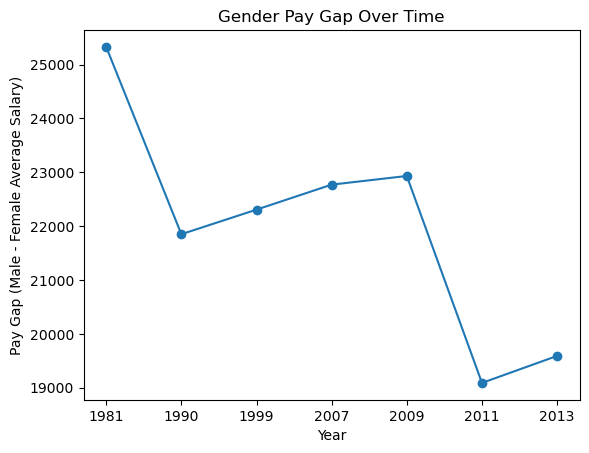

In [7]:
# Convert Spark DataFrame to Pandas for visualization
pay_gap_pandas = pay_gap.toPandas()

# Plot the gender pay gap over time
plt.plot(pay_gap_pandas['year'], pay_gap_pandas['PayGap'], marker='o')
plt.title('Gender Pay Gap Over Time')
plt.xlabel('Year')
plt.ylabel('Pay Gap (Male - Female Average Salary)')
plt.show()

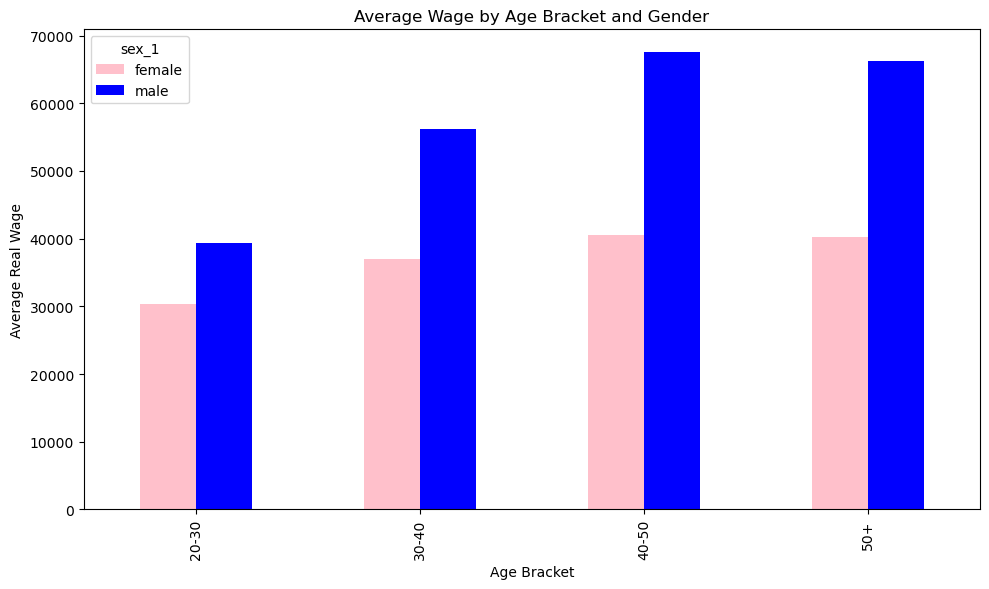

In [8]:
# Convert Spark DataFrame to Pandas
pay_gap_by_age_pd = pay_gap_by_age.toPandas()

# Pivot the DataFrame to have separate columns for male and female real wages
pay_gap_by_age_pivot = pay_gap_by_age_pd.pivot(index='AgeBracket', columns='sex_1', values='avg(real_wage)').fillna(0)

# Set up the plot with the new pivoted DataFrame
ax = pay_gap_by_age_pivot.plot(kind='bar', stacked=False, figsize=(10, 6), color=['pink', 'blue'])

# Set plot labels and title
plt.title('Average Wage by Age Bracket and Gender')
plt.xlabel('Age Bracket')
plt.ylabel('Average Real Wage')

# Display the plot
plt.tight_layout()
plt.show()

In [12]:
from pyspark.sql import functions as F

# Step 1: Group by occupation and gender, and calculate the average salary
occupations = combined_df.groupBy(['occ', 'sex_1']).agg(F.mean('real_wage').alias('avg_salary'))

# Step 2: Pivot the DataFrame to get male and female salaries in separate columns
occupations_pivoted = occupations.groupBy('occ').pivot('sex_1').agg(F.first('avg_salary')).na.fill(0)

# Step 3: Calculate total salary (sum of male and female average salaries) and get top 10 occupations
occupations_pivoted = occupations_pivoted.withColumn('total_salary', occupations_pivoted['male'] + occupations_pivoted['female'])
top_occupations = occupations_pivoted.orderBy('total_salary', ascending=False).limit(10)

# Drop rows where 'occ' is 66, 1520 or 84 (difficulty finding occ codes)
top_occupations = top_occupations[~top_occupations['occ'].isin([66, 84, 1520])]

# Verify that the rows were dropped
top_occupations.show(10)



+----+------------------+------------------+------------------+
| occ|            female|              male|      total_salary|
+----+------------------+------------------+------------------+
|3060| 143920.7629554128|226480.12369363668|370400.88664904947|
|  10|127482.20915185273|184096.63110707406| 311578.8402589268|
|2100|125707.48322237715|181693.26327849666| 307400.7465008738|
|1800|135396.45647439995|153717.15237753253|289113.60885193245|
|3010|111030.20629405118|175785.67576427708|286815.88205832825|
|3256| 136872.0099008732|141467.89081975998| 278339.9007206332|
|1200|123046.55075368396| 153825.3699617469|276871.92071543087|
+----+------------------+------------------+------------------+



In [29]:
# Step 4: Convert to Pandas DataFrame for plotting
top_occupations_pd = top_occupations.toPandas()

# Step 5: Replace 'occ' numeric values with descriptive labels
occupation_mapping = {
    3060: 'Physician',
    10: 'CEO',
    2100: 'Lawyer',
    1800: 'Economist',
    3010: 'Dentist',
    3256: 'Nurse Anesthetists',
    1200: 'Actuary',
    1520: 'Petroleum Engineer'
}
# Ensure the 'occ' column is cast to integer before replacing
top_occupations_pd['occ'] = top_occupations_pd['occ'].astype(int)

# Replace all 'occ' values with descriptive names from the mapping dictionary
top_occupations_pd['occ'] = top_occupations_pd['occ'].replace(occupation_mapping)
top_occupations_pd.head(10)

,occ,female,male,total_salary
0,Physician,143920.762955,226480.123694,370400.886649
1,CEO,127482.209152,184096.631107,311578.840259
2,Lawyer,125707.483222,181693.263278,307400.746501
3,Economist,135396.456474,153717.152378,289113.608852
4,Dentist,111030.206294,175785.675764,286815.882058
5,Nurse Anesthetists,136872.009901,141467.890820,278339.900721
6,Actuary,123046.550754,153825.369962,276871.920715


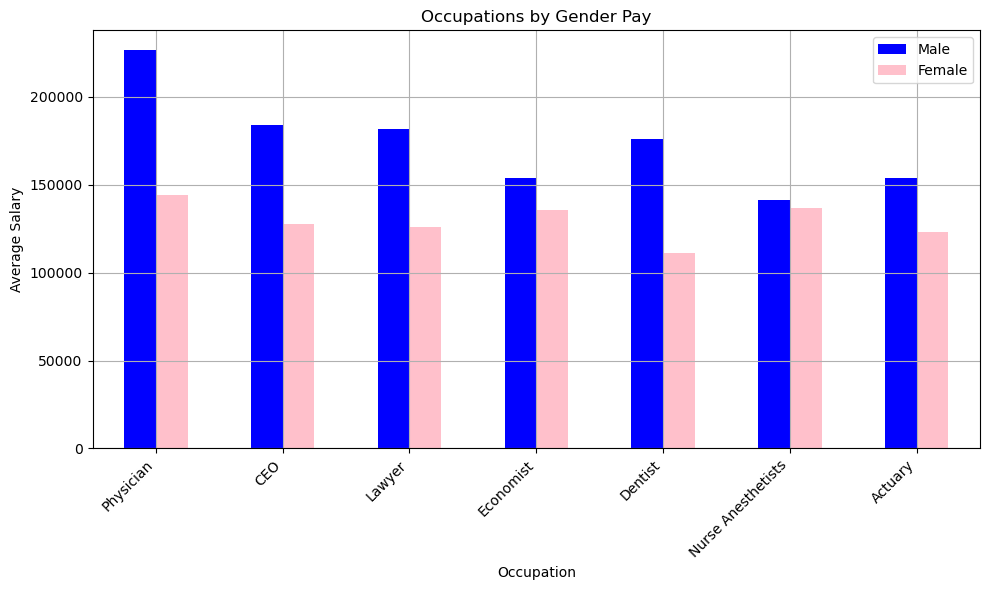

In [30]:
# Step 6: Plot the top 10 occupations with a bar chart using descriptive labels
top_occupations_pd.set_index('occ')[['male', 'female']].plot(kind='bar', stacked=False, figsize=(10, 6), color=['blue', 'pink'])

# Tilt the x-axis labels
plt.xticks(rotation=45, ha='right')

# Step 7: Add labels and title
plt.title('Occupations by Gender Pay')
plt.xlabel('Occupation')
plt.ylabel('Average Salary')
plt.legend(['Male', 'Female'], loc='upper right')
plt.grid(True)

# Step 8: Show the plot
plt.tight_layout()
plt.show()

In [62]:

# Step 1: Filter for women (assuming 'sex_1' = 'female' represents women)
women_occupations = combined_df.filter(combined_df['sex_1'] == 'female')

# Step 2: Group by occupation code and calculate the count of women and average real wage
women_occupation_stats = women_occupations.groupBy('occ').agg(
    F.count('*').alias('count'),
    F.mean('real_wage').alias('avg_real_wage')
)

# Step 3: Order by the number of women in each occupation (descending) and get the top 10
top_women_occupations = women_occupation_stats.orderBy('count', ascending=False).limit(10)

# Step 4: Drop rows where 'occ' is 313, 3130, 4700(for filtering out specific occupations)
top_women_occupations = top_women_occupations.filter(~top_women_occupations['occ'].isin([313, 3130, 4700]))

# Step 5: Convert to Pandas for verification or further analysis
top_women_occupations = top_women_occupations.toPandas()

# Step 6: Show the top 8 rows
print(top_women_occupations.head(8))



    occ  count  avg_real_wage
0  5700   5414   35357.415812
1  2310   4883   45317.675830
2  3600   2919   23695.796025
3  3255   2515   59538.986258
4  4720   2368   17987.138296
5  5240   2152   34135.185578
6  4230   2108   17921.682387


In [64]:


# Step 5: Replace 'occ' numeric values with descriptive labels
occ_women_mapping = {
    5700: 'Secretary',
    2310: 'Teacher',
    3600: 'Nurses Aide',
    3255: 'Registered Nurse',
    4720: 'Cashier',
    5240: 'Customer Service Representative',
    4230: 'Maid'
}
# Ensure the 'occ' column is cast to integer before replacing
top_women_occupations['occ'] = top_women_occupations['occ'].astype(int)

# Replace all 'occ' values with descriptive names from the mapping dictionary
top_women_occupations['occ'] = top_women_occupations['occ'].replace(occ_women_mapping)
top_women_occupations.head()

,occ,count,avg_real_wage
0,Secretary,5414,35357.415812
1,Teacher,4883,45317.675830
2,Nurses Aide,2919,23695.796025
3,Registered Nurse,2515,59538.986258
4,Cashier,2368,17987.138296


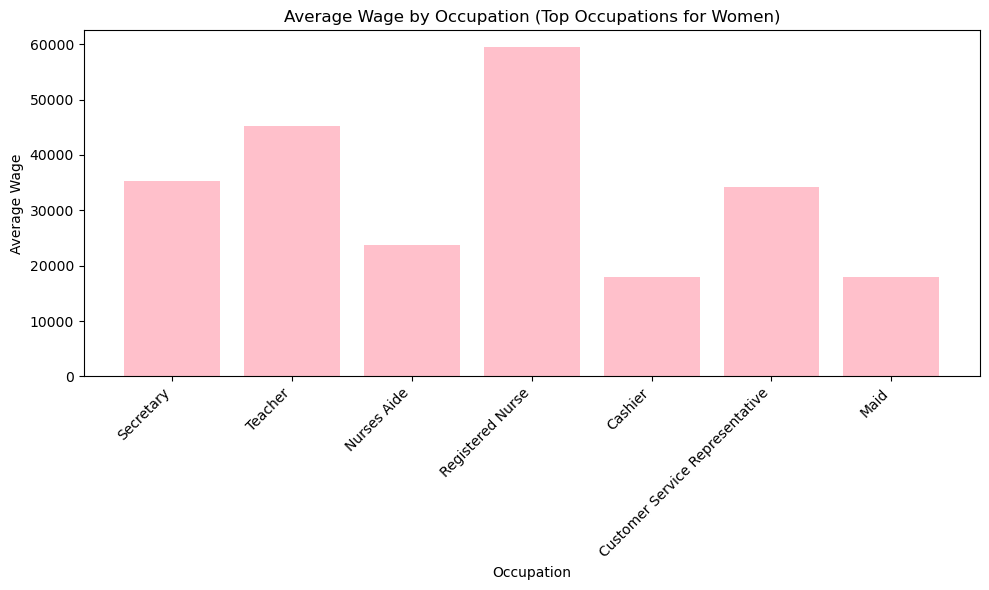

In [76]:
# Step 7: Plot the graph
plt.figure(figsize=(10, 6))
plt.bar(top_women_occupations['occ'], top_women_occupations['avg_real_wage'], color='pink')
plt.xlabel('Occupation')
plt.ylabel('Average Wage')
plt.title('Average Wage by Occupation (Top Occupations for Women)')
plt.xticks(rotation=45, ha='right')  # Tilt the x-axis labels for readability
plt.tight_layout()

# Show the plot
plt.show()

In [72]:
# Step 1: Filter for women (assuming 'sex_1' = 'female' represents women)
men_occupations = combined_df.filter(combined_df['sex_1'] == 'male')

# Step 2: Group by occupation code and calculate the count of women and average real wage
men_occupation_stats = men_occupations.groupBy('occ').agg(
    F.count('*').alias('count'),
    F.mean('real_wage').alias('avg_real_wage')
)

# Step 3: Order by the number of women in each occupation (descending) and get the top 10
top_men_occupations = men_occupation_stats.orderBy('count', ascending=False).limit(10)

# Step 4: Drop rows where 'occ' is 245, 19, 4700(for filtering out specific occupations)
top_men_occupations = top_men_occupations.filter(~top_men_occupations['occ'].isin([245, 19, 4700]))

# Step 5: Convert to Pandas for verification or further analysis
top_men_occupations = top_men_occupations.toPandas()

# Step 6: Show the top 8 rows
print(top_men_occupations.head(8))

    occ  count  avg_real_wage
0  9130   4918   44751.837132
1   430   3143   89548.016678
2  4220   2286   28793.194728
3  9620   1964   31899.031291
4  4760   1723   50595.392361
5  6260   1675   33138.059027
6   804   1628   44130.121854


In [74]:
# Step 5: Replace 'occ' numeric values with descriptive labels
occ_men_mapping = {
    9130: 'Truck Driver',
    430: 'Manager',
    4220: 'Janitor',
    9620: 'Laborer',
    4760: 'Sales',
    6260: 'Construction',
    804: 'Accountant',
}
# Ensure the 'occ' column is cast to integer before replacing
top_men_occupations['occ'] = top_men_occupations['occ'].astype(int)

# Replace all 'occ' values with descriptive names from the mapping dictionary
top_men_occupations['occ'] = top_men_occupations['occ'].replace(occ_men_mapping)
top_men_occupations.head()

,occ,count,avg_real_wage
0,Truck Driver,4918,44751.837132
1,Manager,3143,89548.016678
2,Janitor,2286,28793.194728
3,Laborer,1964,31899.031291
4,Sales,1723,50595.392361


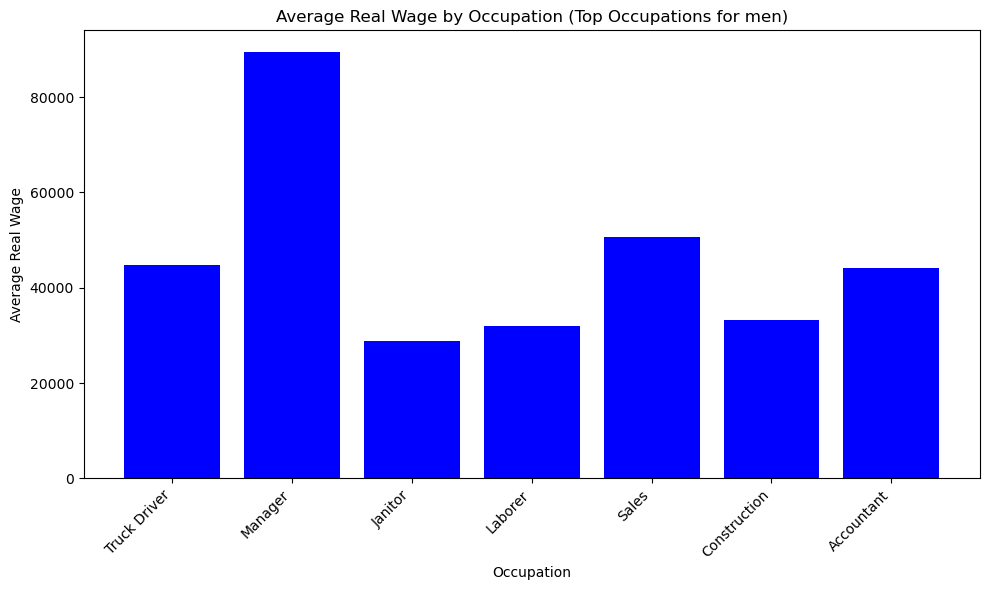

In [75]:
# Step 7: Plot the graph
plt.figure(figsize=(10, 6))
plt.bar(top_men_occupations['occ'], top_men_occupations['avg_real_wage'], color='blue')
plt.xlabel('Occupation')
plt.ylabel('Average Wage')
plt.title('Average Wage by Occupation (Top Occupations for men)')
plt.xticks(rotation=45, ha='right')  # Tilt the x-axis labels for readability
plt.tight_layout()

# Show the plot
plt.show()